# Go straight to predicting the sentiment of the next utterance

In [2]:
from spacy import displacy

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import spacy
import os
from functools import partial

import data
import plot

from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import BernoulliNB
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


/Users/ryan/miniconda3/envs/chatty/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [3]:
train, train_vecs, test, test_vecs = data.get_data(use_cached=True)

train['utter_len'] = train['utter'].map(lambda x: len(x.split(' ')))

train['has_question_mark'] = train['utter'].map(lambda x: 1 if'?' in x.split(' ') else 0)
train = pd.concat([train, data.get_lags(train[['has_question_mark']], lag_range=[1])], axis=1)
train[['utter_t-1', 'utter_t-2', 'utter_t-3']] = data.get_lags(train[['utter']], lag_range=[1, 2, 3])

Using Cached


In [4]:
ACT_MASK = train['act'].notnull() & train['has_question_mark_t-1'].notnull()

assert train['act'][train['act'].notnull()].shape[0] \
      == train_vecs[train['act'].notnull()].shape[0]

TRAIN_MASK = ['first_utterance',
              'subjectivity',
              'utter_len',
              'has_question_mark',
              'has_question_mark_t-1']

X = np.concatenate((train_vecs,
                    train[TRAIN_MASK].values),
                   axis=1)[ACT_MASK]
y = train['act'][ACT_MASK]

In [5]:
from sklearn.ensemble import RandomForestClassifier

In [6]:
results = data.cv_stratified_shuffle(X[::50], y[::50],
                                     RandomForestClassifier(n_jobs=-1),
                                     splits=5,
                                     upsample='SMOTE')

Training
Training
Training
Training
Training


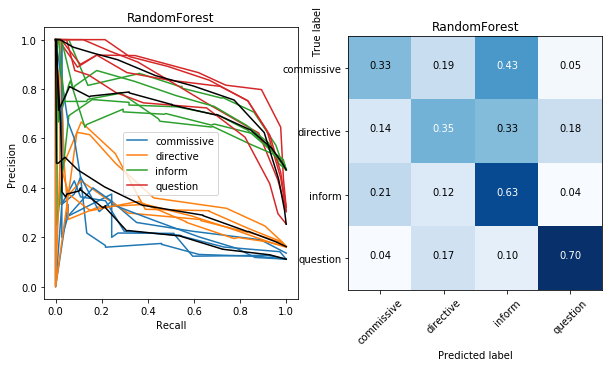

In [7]:
plot.plot_prec_rec(results, "RandomForest", normalize_confusion_matrix=True)

In [346]:
from research.daily_dialogue.data import _file_streams

from chatty.utils.multiprocessing import parmap
from chatty.utils import tokens
%reload_ext chatty.utils.tokens
%reload_ext research

### Include parts of speech, nominal subjects